<a href="https://colab.research.google.com/github/DivijJ16/summer-of-code-2024/blob/main/mlweek3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files


uploaded = files.upload()


Saving marketing.csv to marketing.csv


In [2]:
import io
import numpy as np
import pandas as pd
import datetime
from datetime import date
import matplotlib
from matplotlib.pyplot import plot
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from scipy.stats import boxcox, yeojohnson
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
data=pd.read_csv(io.BytesIO(uploaded['marketing.csv']))

In [4]:
# Feature Engineering

# 1. Combine expense columns into a single feature: Total_Spending
data['Total_Spending'] = data[
    ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
].sum(axis=1)


# 2. Calculate years since becoming a customer from Dt_Customer
data['Customer_Since'] = pd.to_datetime(data['Dt_Customer'], errors='coerce')
data['Customer_Since'] = (pd.Timestamp.now() - data['Customer_Since']).dt.days // 365

# 3. replace the values in the Marital_Status column
data['Marital_Status']=data['Marital_Status'].replace({'Divorced':1,'Single':1,'Married':2,'Together':2,'Absurd':1,'Widow':1,'YOLO':1, 'Alone':1})

# 4. Create Family_Size by summing Kidhome and Teenhome
data['Family_Size'] = data['Kidhome'] + data['Teenhome'] + data['Marital_Status']

#5. Convert Year_Birth to Age
data['Age'] = 2024 - data['Year_Birth']
# 6. Drop irrelevant or constant columns
data_cleaned = data.drop(
    columns=[
        'ID',  # Irrelevant column
        'Dt_Customer',  # Original date column replaced by Customer_Since
        'Z_CostContact', 'Z_Revenue',  # Constant columns
        # Original expense columns consolidated into Total_Spending
        'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
        # Original family size columns consolidated into Family_Size
        'Kidhome', 'Teenhome',
        'Year_Birth'# Original birth year column replaced by Age
    ]
)


# Normalize numerical columns for clustering later
numerical_columns = ['Income','Marital_Status', 'Total_Spending','Age', 'Family_Size', 'Recency', 'Customer_Since','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']
scaler = StandardScaler()
data_cleaned[numerical_columns] = scaler.fit_transform(data_cleaned[numerical_columns])

# Fill missing values for numeric features with the median (or mean if preferred)
numeric_features = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
# Fill missing values with the median for numerical features
data_cleaned[numeric_features] = data_cleaned[numeric_features].fillna(data_cleaned[numeric_features].median())

# Verify if missing values are handled
missing_values_after = data_cleaned.isnull().sum()
print("\nMissing Values After Filling:")
print(missing_values_after)


Missing Values After Filling:
Education              0
Marital_Status         0
Income                 0
Recency                0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
Total_Spending         0
Customer_Since         0
Family_Size            0
Age                    0
dtype: int64


In [5]:
# Display the cleaned dataset structure
print(data_cleaned.head())

    Education  Marital_Status    Income   Recency  NumDealsPurchases  \
0  Graduation       -1.346874  0.234063  0.307039           0.349414   
1  Graduation       -1.346874 -0.234559 -0.383664          -0.168236   
2  Graduation        0.742460  0.769478 -0.798086          -0.685887   
3  Graduation        0.742460 -1.017239 -0.798086          -0.168236   
4         PhD        0.742460  0.240221  1.550305           1.384715   

   NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
0         1.409304             2.510890          -0.550785           0.693904   
1        -1.110409            -0.568720          -1.166125          -0.130463   
2         1.409304            -0.226541           1.295237          -0.542647   
3        -0.750450            -0.910898          -0.550785           0.281720   
4         0.329427             0.115638           0.064556          -0.130463   

   AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
0    

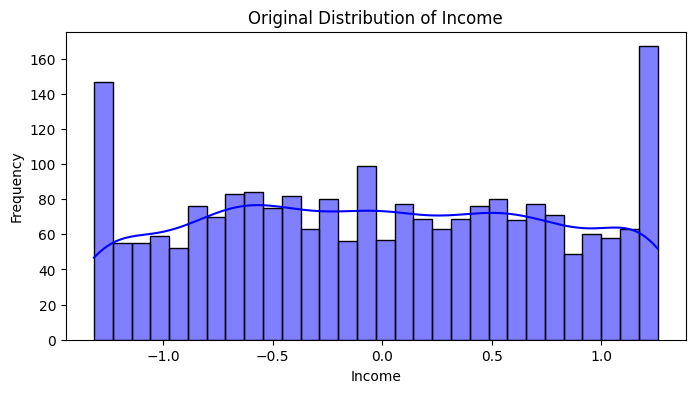

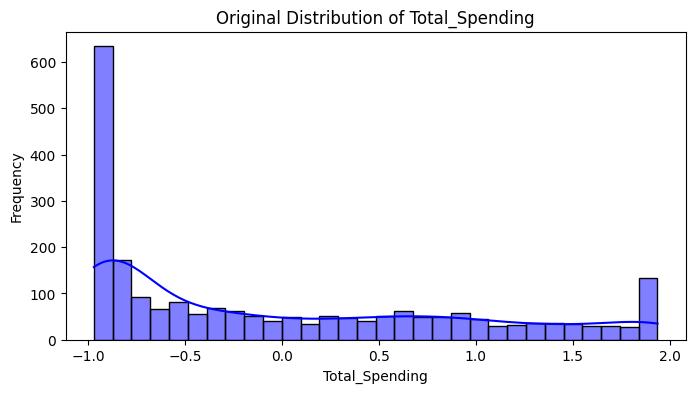

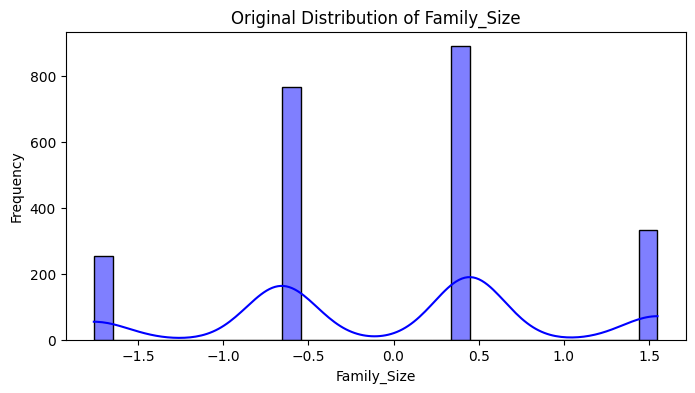

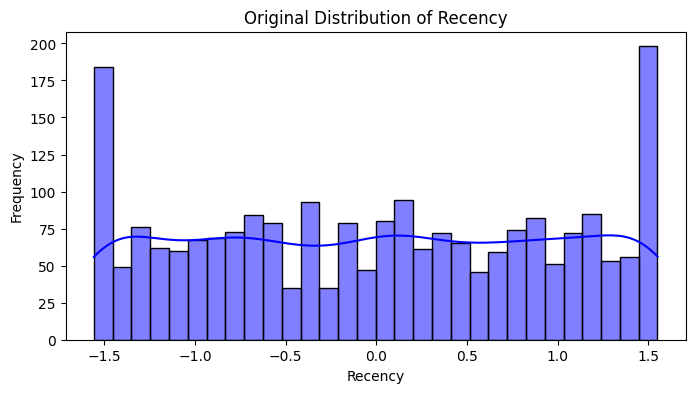

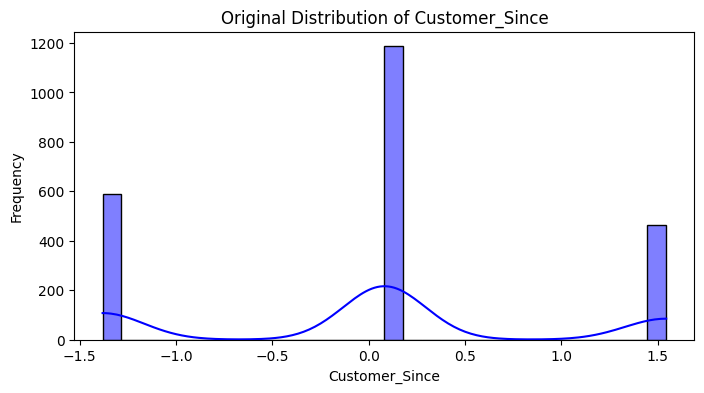

In [8]:
# Example: Features to transform
features_to_transform = ['Income', 'Total_Spending', 'Family_Size', 'Recency', 'Customer_Since']

# Transformations
for feature in features_to_transform:
    # capping the outliers
    lower_limit = data_cleaned[feature].quantile(0.05)
    upper_limit = data_cleaned[feature].quantile(0.95)
    data_cleaned[feature] = data_cleaned[feature].clip(lower=lower_limit, upper=upper_limit)
    # Check skewness before transformation
    plt.figure(figsize=(8, 4))
    sns.histplot(data_cleaned[feature], kde=True, bins=30, color='blue')
    plt.title(f'Original Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()



In [ ]:
    # #  don't run this part of code
    # # Apply Yeo-Johnson Transformation (handles zero and negative values)
    # data_cleaned[feature] = yeojohnson(data_cleaned[feature])

    # # Check skewness after transformation
    # plt.figure(figsize=(8, 4))
    # sns.histplot(data_cleaned[feature], kde=True, bins=30, color='green')
    # plt.title(f'Transformed Distribution of {feature}')
    # plt.xlabel(feature)
    # plt.ylabel('Frequency')
    # plt.show()

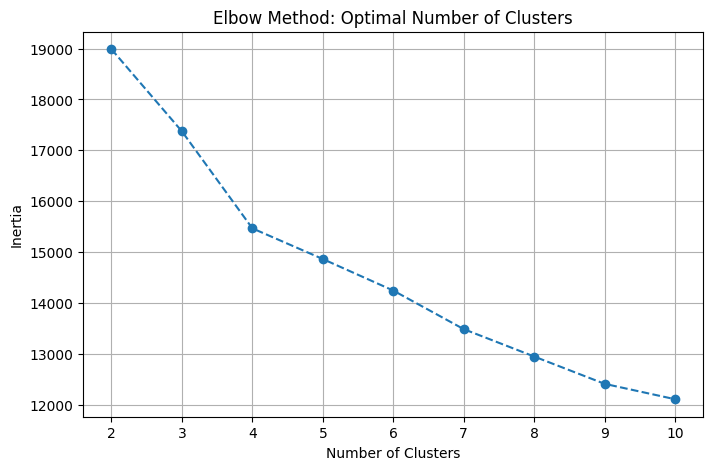

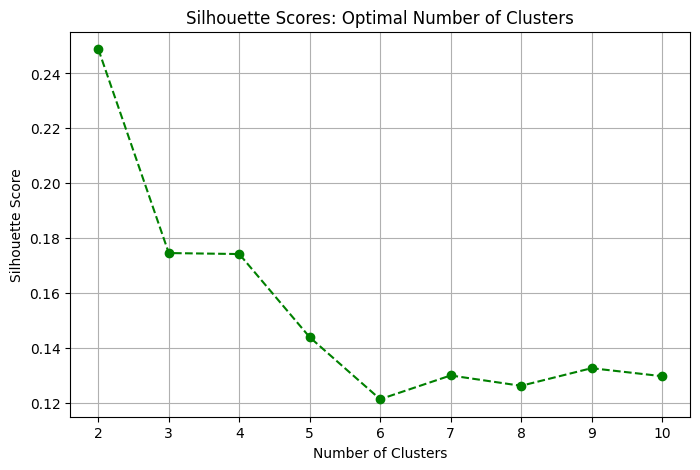

In [9]:
# Selecting only numerical features for clustering
numerical_features = ['Income','Marital_Status', 'Total_Spending','Age', 'Family_Size', 'Recency', 'Customer_Since','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']
X = data_cleaned[numerical_features]

# Elbow Method
inertia = []
cluster_range = range(2, 11)  # Testing cluster counts from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Silhouette Scores
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Silhouette Scores: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()
# we conclude that the optimal number of clusters is 3 based on the elbow method and silhouette scores.

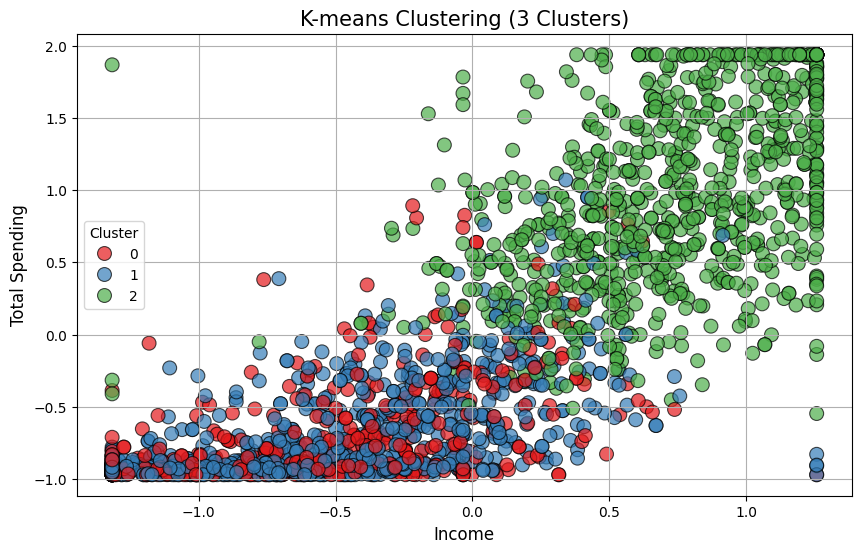

In [10]:
# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
data_cleaned['Cluster'] = kmeans.fit_predict(data_cleaned[numerical_features])

# Visualizing the clusters
# We'll plot the first two features in a 2D space. You can adjust this for more dimensions.

plt.figure(figsize=(10, 6))

# Plotting clusters in 2D (using the first two numerical features for simplicity)
sns.scatterplot(x=data_cleaned['Income'], y=data_cleaned['Total_Spending'],
                hue=data_cleaned['Cluster'], palette="Set1", s=100, alpha=0.7, edgecolor='black')

plt.title('K-means Clustering (3 Clusters)', fontsize=15)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

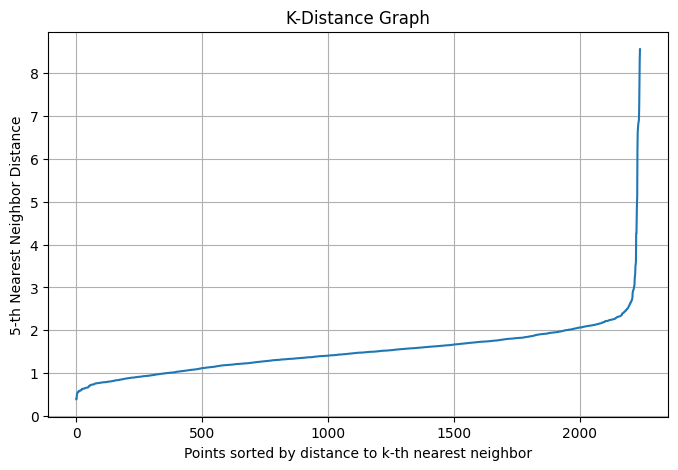

Cluster labels: {0, 1, 2, -1}


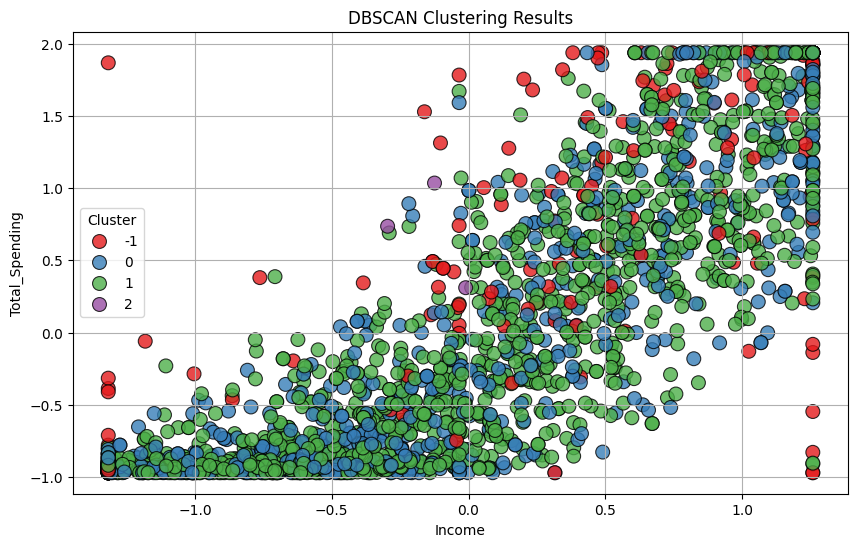

In [11]:
# // DBSCAN Clustering

# 1) Determine the optimal epsilon value


min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data_cleaned[numerical_features])
distances, indices = neighbors_fit.kneighbors(data_cleaned[numerical_features])

# Sort distances for all points to their k-th nearest neighbor
distances = np.sort(distances[:, -1])

# Plot the sorted distances
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance to k-th nearest neighbor')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.grid(True)
plt.show()
#  We estimate eps = 2 as the optimal value for DBSCAN clustering. This is the distance at which the k-distance graph has a significant change in slope.

# 2) Fit DBSCAN model

# Adjust eps and min_samples as needed
dbscan = DBSCAN(eps=2, min_samples=5)
data_cleaned['Cluster'] = dbscan.fit_predict(data_cleaned[numerical_features])

# Step 3: Analyze results
# Print unique cluster labels
print(f"Cluster labels: {set(data_cleaned['Cluster'])}")

# Step 4: Visualize the clusters (using the first two features for simplicity)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_cleaned['Income'],
    y=data_cleaned['Total_Spending'],
    hue=data_cleaned['Cluster'],
    palette='Set1',
    s=100,
    alpha=0.8,
    edgecolor='black'
)
plt.title('DBSCAN Clustering Results')
plt.xlabel('Income')
plt.ylabel('Total_Spending')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
#  We can see that DBSCAN has identified 3 clusters in the data. The clusters are not well-separated, but DBSCAN is able to identify the outliers effectively.
# The estimated number of clusters turned out to be 3, similar to K-means clustering.
#  However, the clusters are not as distinct as in K-means clustering. This is expected as DBSCAN is designed to identify outliers and noise in the data, which may not form well-defined clusters.
